In [ ]:
devtools::install_github("business-science/modeltime.h2o")

TTR          (NA    -> 0.24.3    ) [CRAN]
xts          (NA    -> 0.12.1    ) [CRAN]
quantmod     (NA    -> 0.4.20    ) [CRAN]
quadprog     (NA    -> 1.5-8     ) [CRAN]
parallelly   (NA    -> 1.32.0    ) [CRAN]
listenv      (NA    -> 0.8.0     ) [CRAN]
globals      (NA    -> 0.15.0    ) [CRAN]
RcppArmad... (NA    -> 0.11.2.0.0) [CRAN]
zoo          (NA    -> 1.8-10    ) [CRAN]
timeDate     (NA    -> 3043.102  ) [CRAN]
Rcpp         (NA    -> 1.0.8.3   ) [CRAN]
lmtest       (NA    -> 0.9-40    ) [CRAN]
furrr        (NA    -> 0.3.0     ) [CRAN]
future       (NA    -> 1.26.1    ) [CRAN]
urca         (NA    -> 1.3-0     ) [CRAN]
tseries      (NA    -> 0.10-51   ) [CRAN]
RcppRoll     (NA    -> 0.3.0     ) [CRAN]
forecast     (NA    -> 8.16      ) [CRAN]
fracdiff     (NA    -> 1.5-1     ) [CRAN]
BH           (NA    -> 1.78.0-0  ) [CRAN]
warp         (NA    -> 0.2.0     ) [CRAN]
slider       (NA    -> 0.2.2     ) [CRAN]
SQUAREM      (NA    -> 2021.1    ) [CRAN]
numDeriv     (NA    -> 2016.8-1.1)

Installing 76 packages: TTR, xts, quantmod, quadprog, parallelly, listenv, globals, RcppArmadillo, zoo, timeDate, Rcpp, lmtest, furrr, future, urca, tseries, RcppRoll, forecast, fracdiff, BH, warp, slider, SQUAREM, numDeriv, progressr, future.apply, lava, prodlim, ipred, hardhat, gower, bitops, ps, processx, matrixStats, checkmate, loo, gridExtra, inline, htmlwidgets, RcppEigen, StanHeaders, rstantools, rstan, RcppParallel, extraDistr, dygraphs, iterators, foreach, snakecase, reactR, later, promises, crosstalk, lazyeval, parsnip, DiceDesign, tsfeatures, anytime, padr, plotly, rsample, recipes, RCurl, prophet, xgboost, doParallel, janitor, gt, reactable, workflows, yardstick, dials, timetk, h2o, modeltime

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



* checking for file ‘/tmp/Rtmpv9mnII/remotes3e1ac0a0dd/business-science-modeltime.h2o-ee040b8/DESCRIPTION’ ... OK
* preparing ‘modeltime.h2o’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘modeltime.h2o_0.1.1.9000.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages('pacman')
library(pacman)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
pacman::p_load(tidymodels,tidyverse,timetk,modeltime.h2o)

In [ ]:
fulldata = readRDS("20220617 RB vendas FMCG + indicadores.rds")
fulldata = fulldata %>% janitor::clean_names()
variaveis = data.frame(colunas = colnames(fulldata)[4:(length(fulldata)-2)],
           abrev = c("aprec","pers","clim","de","ho","coincPriv","coincAtiv",
  "confConc","confCom","sent",rep("volum",4),
  "desemp",rep("ipc",4),rep("ihpc",4),"hicp","ipi","ppi","cases",
  "repRate","si","si","gr","ci","es","rr","gp"))
ts <- fulldata %>%
  select(date, kantar) %>%
  set_names(c("date", "value")) 
splits <- ts %>%
  time_series_split(assess = "8 months", cumulative = TRUE,date_var = date)

In [ ]:
h2o.init()

In [ ]:
nested_data_tbl <- walmart_sales_weekly %>%
    select(id, Date, Weekly_Sales) %>% 
  # Step 1: Extend
  extend_timeseries(
    .id_var        = id,
    .date_var      = Date,
    .length_future = 52
  ) %>%
  # Step 2: Nest
  nest_timeseries(
    .id_var        = id,
    .length_future = 52,
    .length_actual = 52*2
  ) %>%
  # Step 3: Split Train/Test
  split_nested_timeseries(
    .length_test = 52
  )
  data_tbl <- walmart_sales_weekly %>%
    select(id, Date, Weekly_Sales)

In [ ]:
rec_prophet <- recipe(Weekly_Sales ~ Date, extract_nested_train_split(nested_data_tbl)) 

wflw_prophet <- workflow() %>%
  add_model(
    prophet_reg("regression", seasonality_yearly = TRUE) %>% 
      set_engine("prophet")
  ) %>%
  add_recipe(rec_prophet)

rec_xgb <- recipe(Weekly_Sales ~ ., extract_nested_train_split(nested_data_tbl)) %>%
  step_timeseries_signature(Date) %>%
  step_rm(Date) %>%
  step_zv(all_predictors()) %>%
  step_dummy(all_nominal_predictors(), one_hot = TRUE)

wflw_xgb <- workflow() %>%
  add_model(boost_tree("regression") %>% set_engine("xgboost")) %>%
  add_recipe(rec_xgb)

nested_modeltime_tbl <- modeltime_nested_fit(
  # Nested data 
  nested_data = nested_data_tbl,
  
  # Add workflows
  wflw_prophet,
  wflw_xgb
)

model_fitted <- model_spec %>%
    fit(Weekly_Sales ~ ., data = train_tbl)

Fitting models on training data... ■■■■■                             14% | ETA:…

Fitting models on training data... ■■■■■■■■■■                        29% | ETA:…

Fitting models on training data... ■■■■■■■■■■■■■■                    43% | ETA:…

Fitting models on training data... ■■■■■■■■■■■■■■■■■■                57% | ETA:…

Fitting models on training data... ■■■■■■■■■■■■■■■■■■■■■■■■■■■       86% | ETA:…

Fitting models on training data... ■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■  100% | ETA:…



In [ ]:
tab_style_by_group <- function(object, ..., style) {
  pacman::p_load(gt)
  subset_log <- object[["_boxhead"]][["type"]]=="row_group"
  grp_col    <- object[["_boxhead"]][["var"]][subset_log] %>% rlang::sym()
  
  object %>%
    tab_style(
      style = style,
      locations = cells_body(
        rows = .[["_data"]] %>%
          rowid_to_column("rowid") %>%
          group_by(!! grp_col) %>%
          filter(...) %>%
          ungroup() %>%
          pull(rowid)
      )
    )
}

nested_modeltime_tbl %>% 
  extract_nested_test_accuracy() %>%
  group_by(id) %>%
  table_modeltime_accuracy(.interactive = F) %>%
  tab_style_by_group(
    rmse == min(rmse),
    style = cell_fill(color = "lightblue")
  )

In [ ]:
splits <- time_series_split(data_tbl, assess = "3 month", cumulative = TRUE)

recipe_spec <- recipe(Weekly_Sales ~ ., data = training(splits)) %>%
    step_timeseries_signature(Date) 

train_tbl <- training(splits) %>% bake(prep(recipe_spec), .)
test_tbl  <- testing(splits) %>% bake(prep(recipe_spec), .)

Using date_var: Date

Data is not ordered by the 'date_var'. Resamples will be arranged by `Date`.

Overlapping Timestamps Detected. Processing overlapping time series together using sliding windows.



In [ ]:
h2o.init(
    nthreads = -1,
    ip       = 'localhost',
    port     = 54321
)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpwP1Kdv/file426d1bfff5/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpwP1Kdv/file4231eba5ca/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: ..... Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         3 seconds 419 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.34.0.6 
    H2O cluster version age:    12 days  
    H2O cluster name:           H2O_started_from_R_root_rjp447 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.17 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:      

In [ ]:
#criando especificações dos modelos
model_spec <- automl_reg(mode = 'regression') %>%
    set_engine(
         engine                     = 'h2o',
         max_runtime_secs           = 200, 
         max_runtime_secs_per_model = 10,
         max_models                 = 20,
         nfolds                     = 5,
         exclude_algos              = c("DeepLearning"),
         verbosity                  = NULL,
         seed                       = 1
    ) 

In [ ]:
#um esforço h2o pra cada conjunto de dados
teste = teste %>% 
  mutate(teste = map(train.split, ~fit(Weekly_Sales ~ .,data=.x,object = model_spec)))

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                                 model_id
1            GBM_grid_1_AutoML_2_20211228_112058_model_21
2 StackedEnsemble_BestOfFamily_8_AutoML_2_20211228_112058
3            GBM_grid_1_AutoML_2_20211228_112058_model_16
4            GBM_grid_1_AutoML_2_20211228_112058_model_20
5                          DRF_1_AutoML_2_20211228_112058
6     StackedEnsemble_Best1000_1_AutoML_2_20211228_112058
  mean_residual_deviance     rmse      mse      mae     rmsle
1               31163191 5582.400 31163191 3435.637 0.1937016
2               37158003 6095.736 37158003 3786.466 0.1966681
3               37729405 6142.427 37729405 3551.182 0.2137393
4               39278630 6267.267 39278630 3541.840 0.2026523
5               40549080 6367.816 40549080 3796.896 0.2070400
6               41563413 6446.969 41563413 4004.081 0.2105065

[44 rows x 6 columns] 



Using top model: GBM_grid_1_AutoML_2_20211228_112058_model_21

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                                                  model_id
1                         XGBoost_grid_1_AutoML_3_20211228_112239_model_22
2 XGBoost_lr_search_selection_AutoML_3_20211228_112239_select_grid_model_4
3                          XGBoost_grid_1_AutoML_3_20211228_112239_model_2
4                                       XGBoost_3_AutoML_3_20211228_112239
5                                       XGBoost_2_AutoML_3_20211228_112239
6                         XGBoost_grid_1_AutoML_3_20211228_112239_model_13
  mean_residual_deviance     rmse     mse      mae     rmsle
1                6275725 2505.140 6275725 1535.762 0.1491165
2                6406480 2531.103 6406480 1484.314 0.1453053
3                6572804 2563.748 6572804 1457.597 0.1404057
4                7388087 2718.104 7388087 1672.070 0.1696455
5                8093372 2844.885 8093372 1760.816 0.1824126
6                8272546 2876.203 8272546 1840.927 0.1957112

[49 rows x 6 columns] 



Using top model: XGBoost_grid_1_AutoML_3_20211228_112239_model_22

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                                                  model_id
1 XGBoost_lr_search_selection_AutoML_4_20211228_112422_select_grid_model_4
2                              GBM_grid_1_AutoML_4_20211228_112422_model_8
3                              GBM_grid_1_AutoML_4_20211228_112422_model_1
4                          XGBoost_grid_1_AutoML_4_20211228_112422_model_6
5                                           GBM_2_AutoML_4_20211228_112422
6                              GBM_grid_1_AutoML_4_20211228_112422_model_3
  mean_residual_deviance     rmse     mse      mae      rmsle
1                3024130 1739.003 3024130 1273.382 0.04870599
2                3072205 1752.771 3072205 1278.410 0.04909854
3                3201730 1789.338 3201730 1353.387 0.05019989
4                3203130 1789.729 3203130 1290.575 0.05017045
5                3221432 1794.835 3221432 1344.834 0.05034360
6                3230304 1797.305 3230304 1358.955 0.05044071

[44 rows x 6 columns] 



Using top model: XGBoost_lr_search_selection_AutoML_4_20211228_112422_select_grid_model_4

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                                                  model_id
1                              GBM_grid_1_AutoML_5_20211228_112534_model_8
2 XGBoost_lr_search_selection_AutoML_5_20211228_112534_select_grid_model_6
3                              GBM_grid_1_AutoML_5_20211228_112534_model_3
4                             GBM_grid_1_AutoML_5_20211228_112534_model_13
5                              GBM_grid_1_AutoML_5_20211228_112534_model_1
6                                           GBM_2_AutoML_5_20211228_112534
  mean_residual_deviance     rmse     mse      mae      rmsle
1                3902564 1975.491 3902564 1456.407 0.05186008
2                3958409 1989.575 3958409 1461.331 0.05216094
3                4031286 2007.806 4031286 1575.559 0.05275768
4                4038079 2009.497 4038079 1547.944 0.05276891
5                4046315 2011.545 4046315 1554.998 0.05280946
6                4120708 2029.953 4120708 1584.788 0.05331407

[44 rows x 6 columns] 



Using top model: GBM_grid_1_AutoML_5_20211228_112534_model_8

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                                 model_id
1    StackedEnsemble_AllModels_5_AutoML_6_20211228_112641
2                          GLM_1_AutoML_6_20211228_112641
3             GBM_grid_1_AutoML_6_20211228_112641_model_8
4    StackedEnsemble_AllModels_1_AutoML_6_20211228_112641
5 StackedEnsemble_BestOfFamily_3_AutoML_6_20211228_112641
6 StackedEnsemble_BestOfFamily_7_AutoML_6_20211228_112641
  mean_residual_deviance     rmse      mse      mae     rmsle
1               73081099 8548.748 73081099 6811.483 0.1149671
2               85645225 9254.471 85645225 7600.294 0.1218563
3               86238057 9286.445 86238057 7620.369 0.1223714
4               86759630 9314.485 86759630 7717.135 0.1227719
5               86979277 9326.268 86979277 7661.056 0.1227243
6               87323388 9344.698 87323388 7666.287 0.1231323

[46 rows x 6 columns] 



Using top model: StackedEnsemble_AllModels_5_AutoML_6_20211228_112641

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                                 model_id
1    StackedEnsemble_AllModels_5_AutoML_7_20211228_112751
2                          GLM_1_AutoML_7_20211228_112751
3 StackedEnsemble_BestOfFamily_2_AutoML_7_20211228_112751
4    StackedEnsemble_AllModels_3_AutoML_7_20211228_112751
5 StackedEnsemble_BestOfFamily_1_AutoML_7_20211228_112751
6 StackedEnsemble_BestOfFamily_7_AutoML_7_20211228_112751
  mean_residual_deviance     rmse      mse      mae     rmsle
1               59809565 7733.664 59809565 6170.492 0.1107614
2               60126824 7754.149 60126824 6600.998 0.1113475
3               61030271 7812.187 61030271 6622.727 0.1122177
4               61680187 7853.673 61680187 6656.607 0.1126884
5               62478415 7904.329 62478415 6656.096 0.1134749
6               63345445 7958.985 63345445 6775.574 0.1141651

[46 rows x 6 columns] 



Using top model: StackedEnsemble_AllModels_5_AutoML_7_20211228_112751

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                                          model_id
1                     GBM_grid_1_AutoML_8_20211228_112857_model_21
2              StackedEnsemble_Best1000_1_AutoML_8_20211228_112857
3                     GBM_grid_1_AutoML_8_20211228_112857_model_16
4          StackedEnsemble_BestOfFamily_8_AutoML_8_20211228_112857
5             StackedEnsemble_AllModels_5_AutoML_8_20211228_112857
6 GBM_lr_annealing_selection_AutoML_8_20211228_112857_select_model
  mean_residual_deviance     rmse      mse      mae      rmsle
1               43037168 6560.272 43037168 5237.709 0.05675668
2               46955737 6852.426 46955737 5461.360 0.05906992
3               49436831 7031.133 49436831 5557.533 0.06083004
4               50461688 7103.639 50461688 5664.730 0.06099023
5               54472815 7380.570 54472815 5906.228 0.06339679
6               55135384 7425.320 55135384 5631.976 0.06445669

[45 rows x 6 columns] 



Using top model: GBM_grid_1_AutoML_8_20211228_112857_model_21



In [ ]:
#criando tabela com os modelos
teste = teste %>% 
  mutate(tbl = map(teste, ~modeltime_table(.x)))

In [ ]:
#extraindo dados de treino pra usar nas próximas funções
teste = nested_data_tbl
datalist = c()
for (i in 1:nrow(teste)){
  datalist[[i]]= extract_nested_train_split(teste[i,])
}
teste$train.split = datalist

In [ ]:
#extraindo dados de teste pra usar nas próximas funções
datalist = c()
for (i in 1:nrow(teste)){
  datalist[[i]]= extract_nested_test_split(teste[i,])
}
teste$test.split = datalist

In [ ]:
#gerando objeto de calibração
teste = teste %>% 
  mutate(calib = map2(tbl,test.split, ~modeltime_calibrate(.x,.y)))

Converting to H2OFrame...



  |======================================================================| 100%
  |======================================================================| 100%


Converting to H2OFrame...



  |======================================================================| 100%
  |======================================================================| 100%


Converting to H2OFrame...



  |======================================================================| 100%
  |======================================================================| 100%


Converting to H2OFrame...



  |======================================================================| 100%
  |======================================================================| 100%


Converting to H2OFrame...



  |======================================================================| 100%
  |======================================================================| 100%


Converting to H2OFrame...



  |======================================================================| 100%
  |======================================================================| 100%


Converting to H2OFrame...



  |======================================================================| 100%
  |======================================================================| 100%


In [ ]:
#avaliando modelos com base no fit (train)
teste = teste %>% 
  mutate(acc = map(calib, ~modeltime_accuracy(.x)))

Warning message:
“A correlation computation is required, but `estimate` is constant and has 0 standard deviation, resulting in a divide by 0 error. `NA` will be returned.”
Warning message:
“A correlation computation is required, but `estimate` is constant and has 0 standard deviation, resulting in a divide by 0 error. `NA` will be returned.”
Warning message:
“A correlation computation is required, but `estimate` is constant and has 0 standard deviation, resulting in a divide by 0 error. `NA` will be returned.”
Warning message:
“A correlation computation is required, but `estimate` is constant and has 0 standard deviation, resulting in a divide by 0 error. `NA` will be returned.”
Warning message:
“A correlation computation is required, but `estimate` is constant and has 0 standard deviation, resulting in a divide by 0 error. `NA` will be returned.”
Warning message:
“A correlation computation is required, but `estimate` is constant and has 0 standard deviation, resulting in a divide by 0

In [ ]:
#refit_tbl <- calibration_tbl %>%
#    modeltime_refit(data = m750)

    #avaliando modelos com base no fit (train)
teste = teste %>% 
  mutate(refit = map2(calib,.actual_data, ~modeltime_refit(.x,.y)))

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                                 model_id
1 StackedEnsemble_BestOfFamily_5_AutoML_9_20211228_121421
2                          GBM_5_AutoML_9_20211228_121421
3    StackedEnsemble_AllModels_5_AutoML_9_20211228_121421
4                          XRT_1_AutoML_9_20211228_121421
5 StackedEnsemble_BestOfFamily_3_AutoML_9_20211228_121421
6    StackedEnsemble_AllModels_2_AutoML_9_20211228_121421
  mean_residual_deviance     rmse      mse      mae     rmsle
1               45617648 6754.084 45617648 3922.106 0.2138296
2               47876360 6919.275 47876360 3903.436 0.2186074
3               48164473 6940.063 48164473 4380.746 0.2304582
4               50388500 7098.486 50388500 4073.703 0.2199454
5               50654516 7117.199 50654516 3977.705 0.2217711
6               51367153 7167.088 51367153 4132.980 0.2239615

[32 rows x 6 columns] 



Using top model: StackedEnsemble_BestOfFamily_5_AutoML_9_20211228_121421

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                                  model_id
1                          XRT_1_AutoML_10_20211228_121506
2         XGBoost_grid_1_AutoML_10_20211228_121506_model_1
3 StackedEnsemble_BestOfFamily_7_AutoML_10_20211228_121506
4             GBM_grid_1_AutoML_10_20211228_121506_model_2
5         XGBoost_grid_1_AutoML_10_20211228_121506_model_2
6 StackedEnsemble_BestOfFamily_4_AutoML_10_20211228_121506
  mean_residual_deviance     rmse      mse      mae     rmsle
1               13885448 3726.318 13885448 1887.785 0.1677511
2               16432624 4053.717 16432624 2182.367 0.2111030
3               17039835 4127.933 17039835 2042.347 0.1828800
4               17547280 4188.947 17547280 2213.613 0.1852041
5               17704673 4207.692 17704673 2058.883 0.1850913
6               18470722 4297.758 18470722 2093.920 0.1851830

[33 rows x 6 columns] 



Using top model: XRT_1_AutoML_10_20211228_121506

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                      model_id mean_residual_deviance     rmse
1 GBM_grid_1_AutoML_11_20211228_121557_model_4                3998311 1999.578
2              GBM_2_AutoML_11_20211228_121557                4002291 2000.573
3 GBM_grid_1_AutoML_11_20211228_121557_model_1                4013432 2003.355
4              GBM_3_AutoML_11_20211228_121557                4031387 2007.831
5              GBM_4_AutoML_11_20211228_121557                4046406 2011.568
6 GBM_grid_1_AutoML_11_20211228_121557_model_3                4061899 2015.415
      mse      mae      rmsle
1 3998311 1499.741 0.05453367
2 4002291 1517.128 0.05437905
3 4013432 1500.648 0.05447433
4 4031387 1512.723 0.05455630
5 4046406 1530.889 0.05469370
6 4061899 1523.059 0.05487670

[33 rows x 6 columns] 



Using top model: GBM_grid_1_AutoML_11_20211228_121557_model_4

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                                  model_id
1             GBM_grid_1_AutoML_12_20211228_121644_model_4
2 StackedEnsemble_BestOfFamily_7_AutoML_12_20211228_121644
3             GBM_grid_1_AutoML_12_20211228_121644_model_3
4             GBM_grid_1_AutoML_12_20211228_121644_model_1
5                          GBM_3_AutoML_12_20211228_121644
6                          GBM_4_AutoML_12_20211228_121644
  mean_residual_deviance     rmse     mse      mae      rmsle
1                5037947 2244.537 5037947 1708.905 0.05771776
2                5180616 2276.097 5180616 1717.124 0.05856860
3                5227457 2286.363 5227457 1756.295 0.05873181
4                5361645 2315.523 5361645 1767.414 0.05945108
5                5538154 2353.328 5538154 1825.413 0.06033141
6                5630725 2372.915 5630725 1856.123 0.06085812

[33 rows x 6 columns] 



Using top model: GBM_grid_1_AutoML_12_20211228_121644_model_4

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                                  model_id
1    StackedEnsemble_AllModels_6_AutoML_13_20211228_121730
2                          GLM_1_AutoML_13_20211228_121730
3    StackedEnsemble_AllModels_1_AutoML_13_20211228_121730
4 StackedEnsemble_BestOfFamily_4_AutoML_13_20211228_121730
5 StackedEnsemble_BestOfFamily_3_AutoML_13_20211228_121730
6 StackedEnsemble_BestOfFamily_7_AutoML_13_20211228_121730
  mean_residual_deviance      rmse       mse      mae     rmsle
1               98454480  9922.423  98454480 7881.432 0.1261890
2               98551654  9927.319  98551654 7908.693 0.1262332
3               98970940  9948.414  98970940 7895.010 0.1264747
4               99483409  9974.137  99483409 7943.575 0.1269268
5               99987091  9999.355  99987091 7943.950 0.1271265
6              100650548 10032.475 100650548 7981.960 0.1276459

[33 rows x 6 columns] 



Using top model: StackedEnsemble_AllModels_6_AutoML_13_20211228_121730

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                                  model_id
1             GBM_grid_1_AutoML_14_20211228_121816_model_4
2 StackedEnsemble_BestOfFamily_4_AutoML_14_20211228_121816
3 StackedEnsemble_BestOfFamily_7_AutoML_14_20211228_121816
4                          GLM_1_AutoML_14_20211228_121816
5    StackedEnsemble_AllModels_3_AutoML_14_20211228_121816
6 StackedEnsemble_BestOfFamily_1_AutoML_14_20211228_121816
  mean_residual_deviance     rmse      mse      mae     rmsle
1               73261208 8559.276 73261208 7259.143 0.1172218
2               76019669 8718.926 76019669 7238.979 0.1193118
3               76156139 8726.748 76156139 7306.718 0.1194397
4               76643202 8754.610 76643202 7192.909 0.1196722
5               76744085 8760.370 76744085 7234.035 0.1197870
6               76913209 8770.018 76913209 7174.027 0.1199821

[33 rows x 6 columns] 



Using top model: GBM_grid_1_AutoML_14_20211228_121816_model_4

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                               model_id mean_residual_deviance
1          GBM_grid_1_AutoML_15_20211228_121902_model_3               60683176
2                       XRT_1_AutoML_15_20211228_121902               60876346
3          GBM_grid_1_AutoML_15_20211228_121902_model_1               61252135
4 StackedEnsemble_AllModels_3_AutoML_15_20211228_121902               61813019
5                       GBM_4_AutoML_15_20211228_121902               63375934
6                       GBM_5_AutoML_15_20211228_121902               63482158
      rmse      mse      mae      rmsle
1 7789.941 60683176 6244.914 0.06508879
2 7802.330 60876346 6089.512 0.06561209
3 7826.374 61252135 6369.784 0.06536663
4 7862.126 61813019 6106.311 0.06603590
5 7960.900 63375934 6440.868 0.06638294
6 7967.569 63482158 6093.652 0.06765996

[33 rows x 6 columns] 



Using top model: GBM_grid_1_AutoML_15_20211228_121902_model_3



In [ ]:
#combinando tabela com o melhor modelo pra cada conjunto de dados
bind_cols(id = teste$id,bind_rows(teste$acc)) %>% select(-c(.model_id))

id,.model_desc,.type,mae,mape,mase,smape,rmse,rsq
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1_1,H2O AUTOML - GBM,Test,11214.610,55.007795,2.2111937,43.236653,12090.594,NA
1_3,H2O AUTOML - XGBOOST,Test,4754.249,23.766467,1.8451911,29.595107,9506.150,NA
1_8,H2O AUTOML - XGBOOST,Test,3776.196,9.753073,1.6064327,10.399656,4347.026,NA
1_13,H2O AUTOML - GBM,Test,2190.315,5.416634,0.8062536,5.540635,2967.873,NA
1_38,H2O AUTOML - STACKEDENSEMBLE,Test,10572.167,14.367056,0.9030232,13.284004,12472.657,NA
1_93,H2O AUTOML - STACKEDENSEMBLE,Test,8384.591,10.575342,0.8439442,10.997244,9932.096,NA
1_95,H2O AUTOML - GBM,Test,15532.683,12.161286,1.8703083,13.084233,17722.032,NA


In [ ]:
save(teste,file="teste.rdata")

Daqui pra baixo foi a primeira tentativa, de um fit em um só conjunto de dados

In [ ]:
model_fitted <- model_spec %>%
    fit(Weekly_Sales ~ ., data = train_tbl)

ERROR: ignored

In [ ]:
modeltime_tbl <- modeltime_table(
    model_fitted
) 

modeltime_tbl

Converting to H2OFrame...



  |======================================================================| 100%
  |======================================================================| 100%


Converting to H2OFrame...



  |======================================================================| 100%
  |======================================================================| 100%


Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


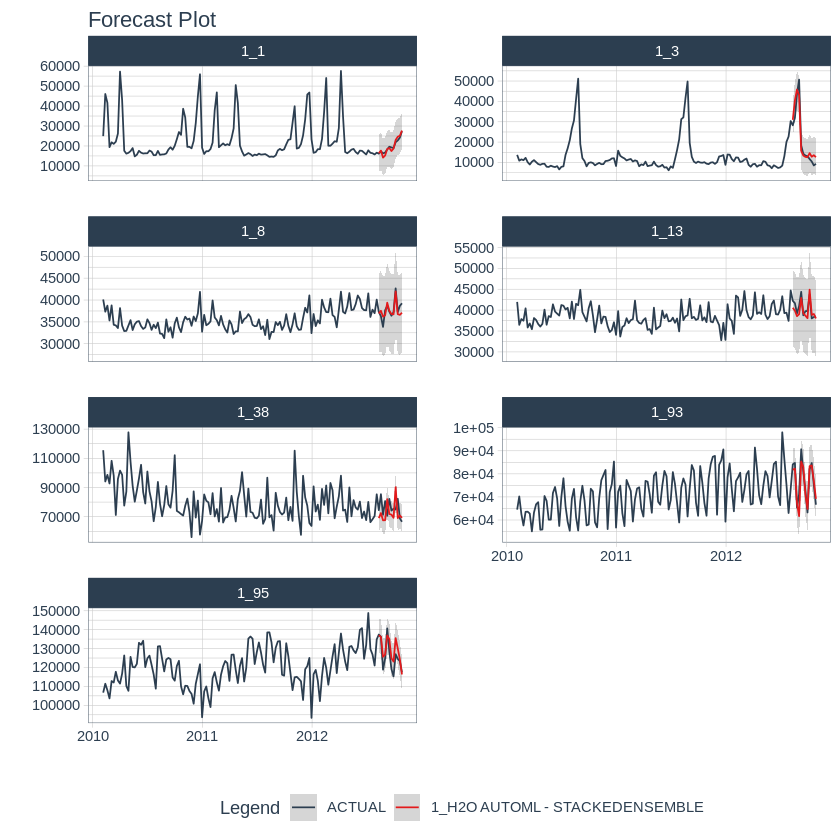

In [ ]:
modeltime_tbl %>%
  modeltime_calibrate(test_tbl) %>%
    modeltime_forecast(
        new_data    = test_tbl,
        actual_data = data_tbl,
        keep_data   = TRUE
    ) %>%
    group_by(id) %>%
    plot_modeltime_forecast(
        .facet_ncol = 2, 
        .interactive = FALSE
    )

In [ ]:
data_prepared_tbl <- bind_rows(train_tbl, test_tbl)

future_tbl <- data_prepared_tbl %>%
    group_by(id) %>%
    future_frame(.length_out = "1 year") %>%
    ungroup()

future_prepared_tbl <- bake(prep(recipe_spec), future_tbl)

.date_var is missing. Using: Date



In [ ]:
refit_tbl <- modeltime_tbl %>%
    modeltime_refit(data_prepared_tbl)

Converting to H2OFrame...



  |======================================================================| 100%



Training H2O AutoML...



  |======================================================================| 100%
  |======================================================================| 100%




Leaderboard: 



                                                 model_id
1    StackedEnsemble_AllModels_3_AutoML_2_20211227_165659
2 StackedEnsemble_BestOfFamily_4_AutoML_2_20211227_165659
3        XGBoost_grid_1_AutoML_2_20211227_165659_model_14
4        XGBoost_grid_1_AutoML_2_20211227_165659_model_13
5    StackedEnsemble_AllModels_2_AutoML_2_20211227_165659
6        XGBoost_grid_1_AutoML_2_20211227_165659_model_11
  mean_residual_deviance     rmse      mse      mae     rmsle
1               30642291 5535.548 30642291 3373.331 0.1288225
2               31339636 5598.182 31339636 3386.112 0.1294276
3               31465693 5609.429 31465693 3414.838 0.1284299
4               32199428 5674.454 32199428 3549.369 0.1398201
5               32522245 5702.828 32522245 3606.213 0.1384024
6               32931827 5738.626 32931827 3608.609 0.1438501

[53 rows x 6 columns] 



Using top model: StackedEnsemble_AllModels_3_AutoML_2_20211227_165659



Converting to H2OFrame...



  |======================================================================| 100%
  |======================================================================| 100%


Warning message:
“Expecting the following names to be in the data frame: .conf_hi, .conf_lo. 
Proceeding with '.conf_interval_show = FALSE' to visualize the forecast without confidence intervals.
Alternatively, try using `modeltime_calibrate()` before forecasting to add confidence intervals.”


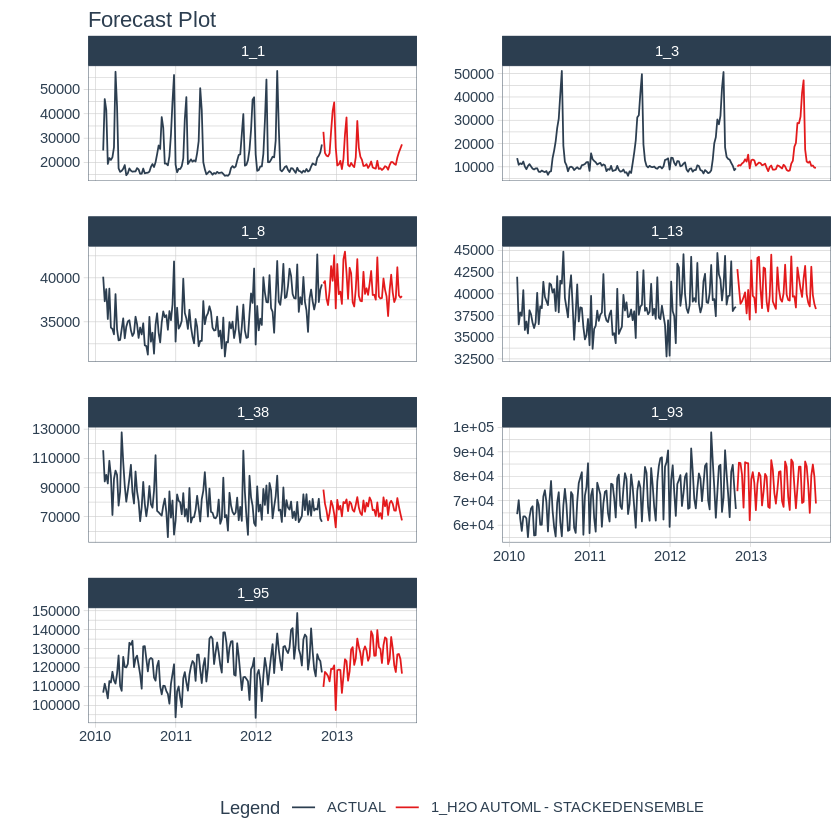

In [ ]:
refit_tbl %>%
    modeltime_forecast(
        new_data    = future_prepared_tbl,
        actual_data = data_prepared_tbl,
        keep_data   = TRUE
    ) %>%
    group_by(id) %>%
    plot_modeltime_forecast(
        .facet_ncol  = 2,
        .interactive = FALSE
    )

In [ ]:
model_fitted %>% 
  save_h2o_model(path = "../model_fitted", overwrite = TRUE)


Model saved at path: ../model_fitted



In [ ]:
pacman::p_load(reticulate)


In [ ]:
devtools::install_github("business-science/modeltime.gluonts")
library(modeltime.gluonts)

Skipping install of 'modeltime.gluonts' from a github remote, the SHA1 (f4eec5f0) has not changed since last install.
  Use `force = TRUE` to force installation



In [ ]:
#reticulate::py_config()
reticulate::conda_list()
#reticulate::conda_version()

ERROR: ignored

In [ ]:
install_miniconda()

Daqui pra baixo é teste com modelo de Deep Learning

In [ ]:
install_gluonts()

In [ ]:
data <- m4_hourly %>%
  select(id, date, value) %>%
  group_by(id) %>%
  mutate(value = standardize_vec(value)) %>%
  ungroup()

data

In [ ]:
HORIZON <- 24*7

new_data <- data %>%
  group_by(id) %>%
  future_frame(.length_out = HORIZON) %>%
  ungroup()

new_data

In [ ]:
head(data)

In [ ]:
model_fit_nbeats_ensemble <- nbeats(
  id                    = "id",
  freq                  = "H",
  prediction_length     = 168,
  lookback_length       = c(168, 672),
  epochs                = 5,
  num_batches_per_epoch = 15,
  batch_size            = 1 
) 

In [ ]:
model_fit_nbeats_ensemble %>%
  set_engine("gluonts_nbeats_ensemble") %>%
  fit(value ~ date + id, data)

In [ ]:
##
https://business-science.github.io/modeltime/articles/getting-started-with-modeltime.html